In this tutorial, we'll use the same type of synthetic EEG dataset introduced in the <a href="../tutorials/experimentalists.html" target="_blank" rel="noopener">Experimentalists tutorial</a>
 as an example.

DataFrame shape: (19000, 7)


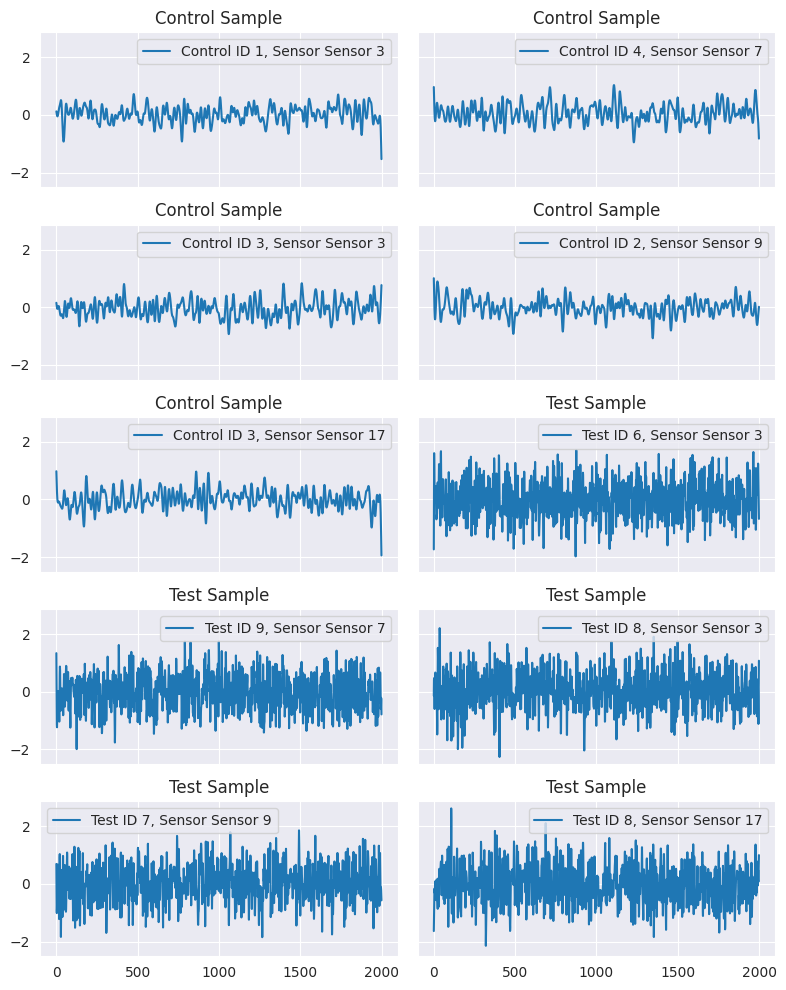

In [1]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt

# Parameters
n_ids = 10
n_epochs = 100
n_sensors = 19
fs = 100  # Sampling frequency
signal_length = 2000  # Number of time points
control_cutoff = 5  # Low-pass filter cutoff for control group
test_cutoff = 20  # Low-pass filter cutoff for test group

# Generate low-pass filter
def low_pass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

# Generate synthetic data
data = []
for id_num in range(1, n_ids + 1):
    group = 'Control' if id_num <= n_ids // 2 else 'Test'
    cutoff = control_cutoff if group == 'Control' else test_cutoff
    for epoch in range(n_epochs):
        for sensor in range(n_sensors):
            # Generate random signal and apply low-pass filter
            raw_signal = np.random.randn(signal_length)
            filtered_signal = low_pass_filter(raw_signal, cutoff, fs)
            data.append({
                'ID': id_num,
                'Group': group,
                'Epoch': epoch,
                'Sensor': f'Sensor {sensor + 1}',
                'Data': filtered_signal,
                'Recording': 'EEG',
                'fs': fs
            })

# Create DataFrame
df = pd.DataFrame(data)
print(f"DataFrame shape: {df.shape}")

# Separate control and test groups
control_data = df[df['Group'] == 'Control']
test_data = df[df['Group'] == 'Test']

# Randomly select 5 samples from each group
control_samples = control_data.sample(5, random_state=42)
test_samples = test_data.sample(5, random_state=42)

# Plot the samples
fig, axes = plt.subplots(5, 2, figsize=(8, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, (idx, row) in enumerate(control_samples.iterrows()):
    axes[i].plot(row['Data'], label=f"Control ID {row['ID']}, Sensor {row['Sensor']}")
    axes[i].legend()
    axes[i].set_title("Control Sample")

for i, (idx, row) in enumerate(test_samples.iterrows(), start=5):
    axes[i].plot(row['Data'], label=f"Test ID {row['ID']}, Sensor {row['Sensor']}")
    axes[i].legend()
    axes[i].set_title("Test Sample")

plt.tight_layout()
plt.show()

Now let's extract some representative features using `ncpi`'s `Features` class — specifically, `catch22` and `1/f slope` features. For some of these, we'll need to pass in a few parameters to configure how the features are extracted. Don't worry about performance — feature computation runs behind the scenes using multi-threading to speed things up.

In [4]:
import ncpi
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid DeprecationWarning from the fooof package

feat_methods = ['catch22', 'power_spectrum_parameterization']

# catch22 params
params = [None]

# 1/f slope params
fooof_setup_emp = {'peak_threshold': 1.,
                   'min_peak_height': 0.,
                   'max_n_peaks': 5,
                   'peak_width_limits': (10., 50.)}
params.append({'fs': df['fs'][0],
               'fmin': 5.,
               'fmax': 45.,
               'fooof_setup': fooof_setup_emp,
               'r_squared_th':0.9})

all_features = {}

for (feat_mt, pm) in zip(feat_methods, params):
    print(f"\nFeature method: {feat_mt}")
    print("Parameters:", pm)
    print("\n")
    features = ncpi.Features(method=feat_mt, params=pm)
    emp_data = df.copy()
    emp_data = features.compute_features(emp_data)

    # Keep only the aperiodic exponent (1/f slope)
    if feat_mt == 'power_spectrum_parameterization':
        emp_data['Features'] = emp_data['Features'].apply(lambda x: x[1])

    all_features[feat_mt] = emp_data['Features']


Feature method: catch22
Parameters: None




Computing features: 100%|██████████| 323/323 [00:21<00:00, 15.21it/s]



Feature method: power_spectrum_parameterization
Parameters: {'fs': np.int64(100), 'fmin': 5.0, 'fmax': 45.0, 'fooof_setup': {'peak_threshold': 1.0, 'min_peak_height': 0.0, 'max_n_peaks': 5, 'peak_width_limits': (10.0, 50.0)}, 'r_squared_th': 0.9}




Computing features: 100%|██████████| 323/323 [00:08<00:00, 40.12it/s]


Finally, let's visualize how the feature distributions vary across groups.

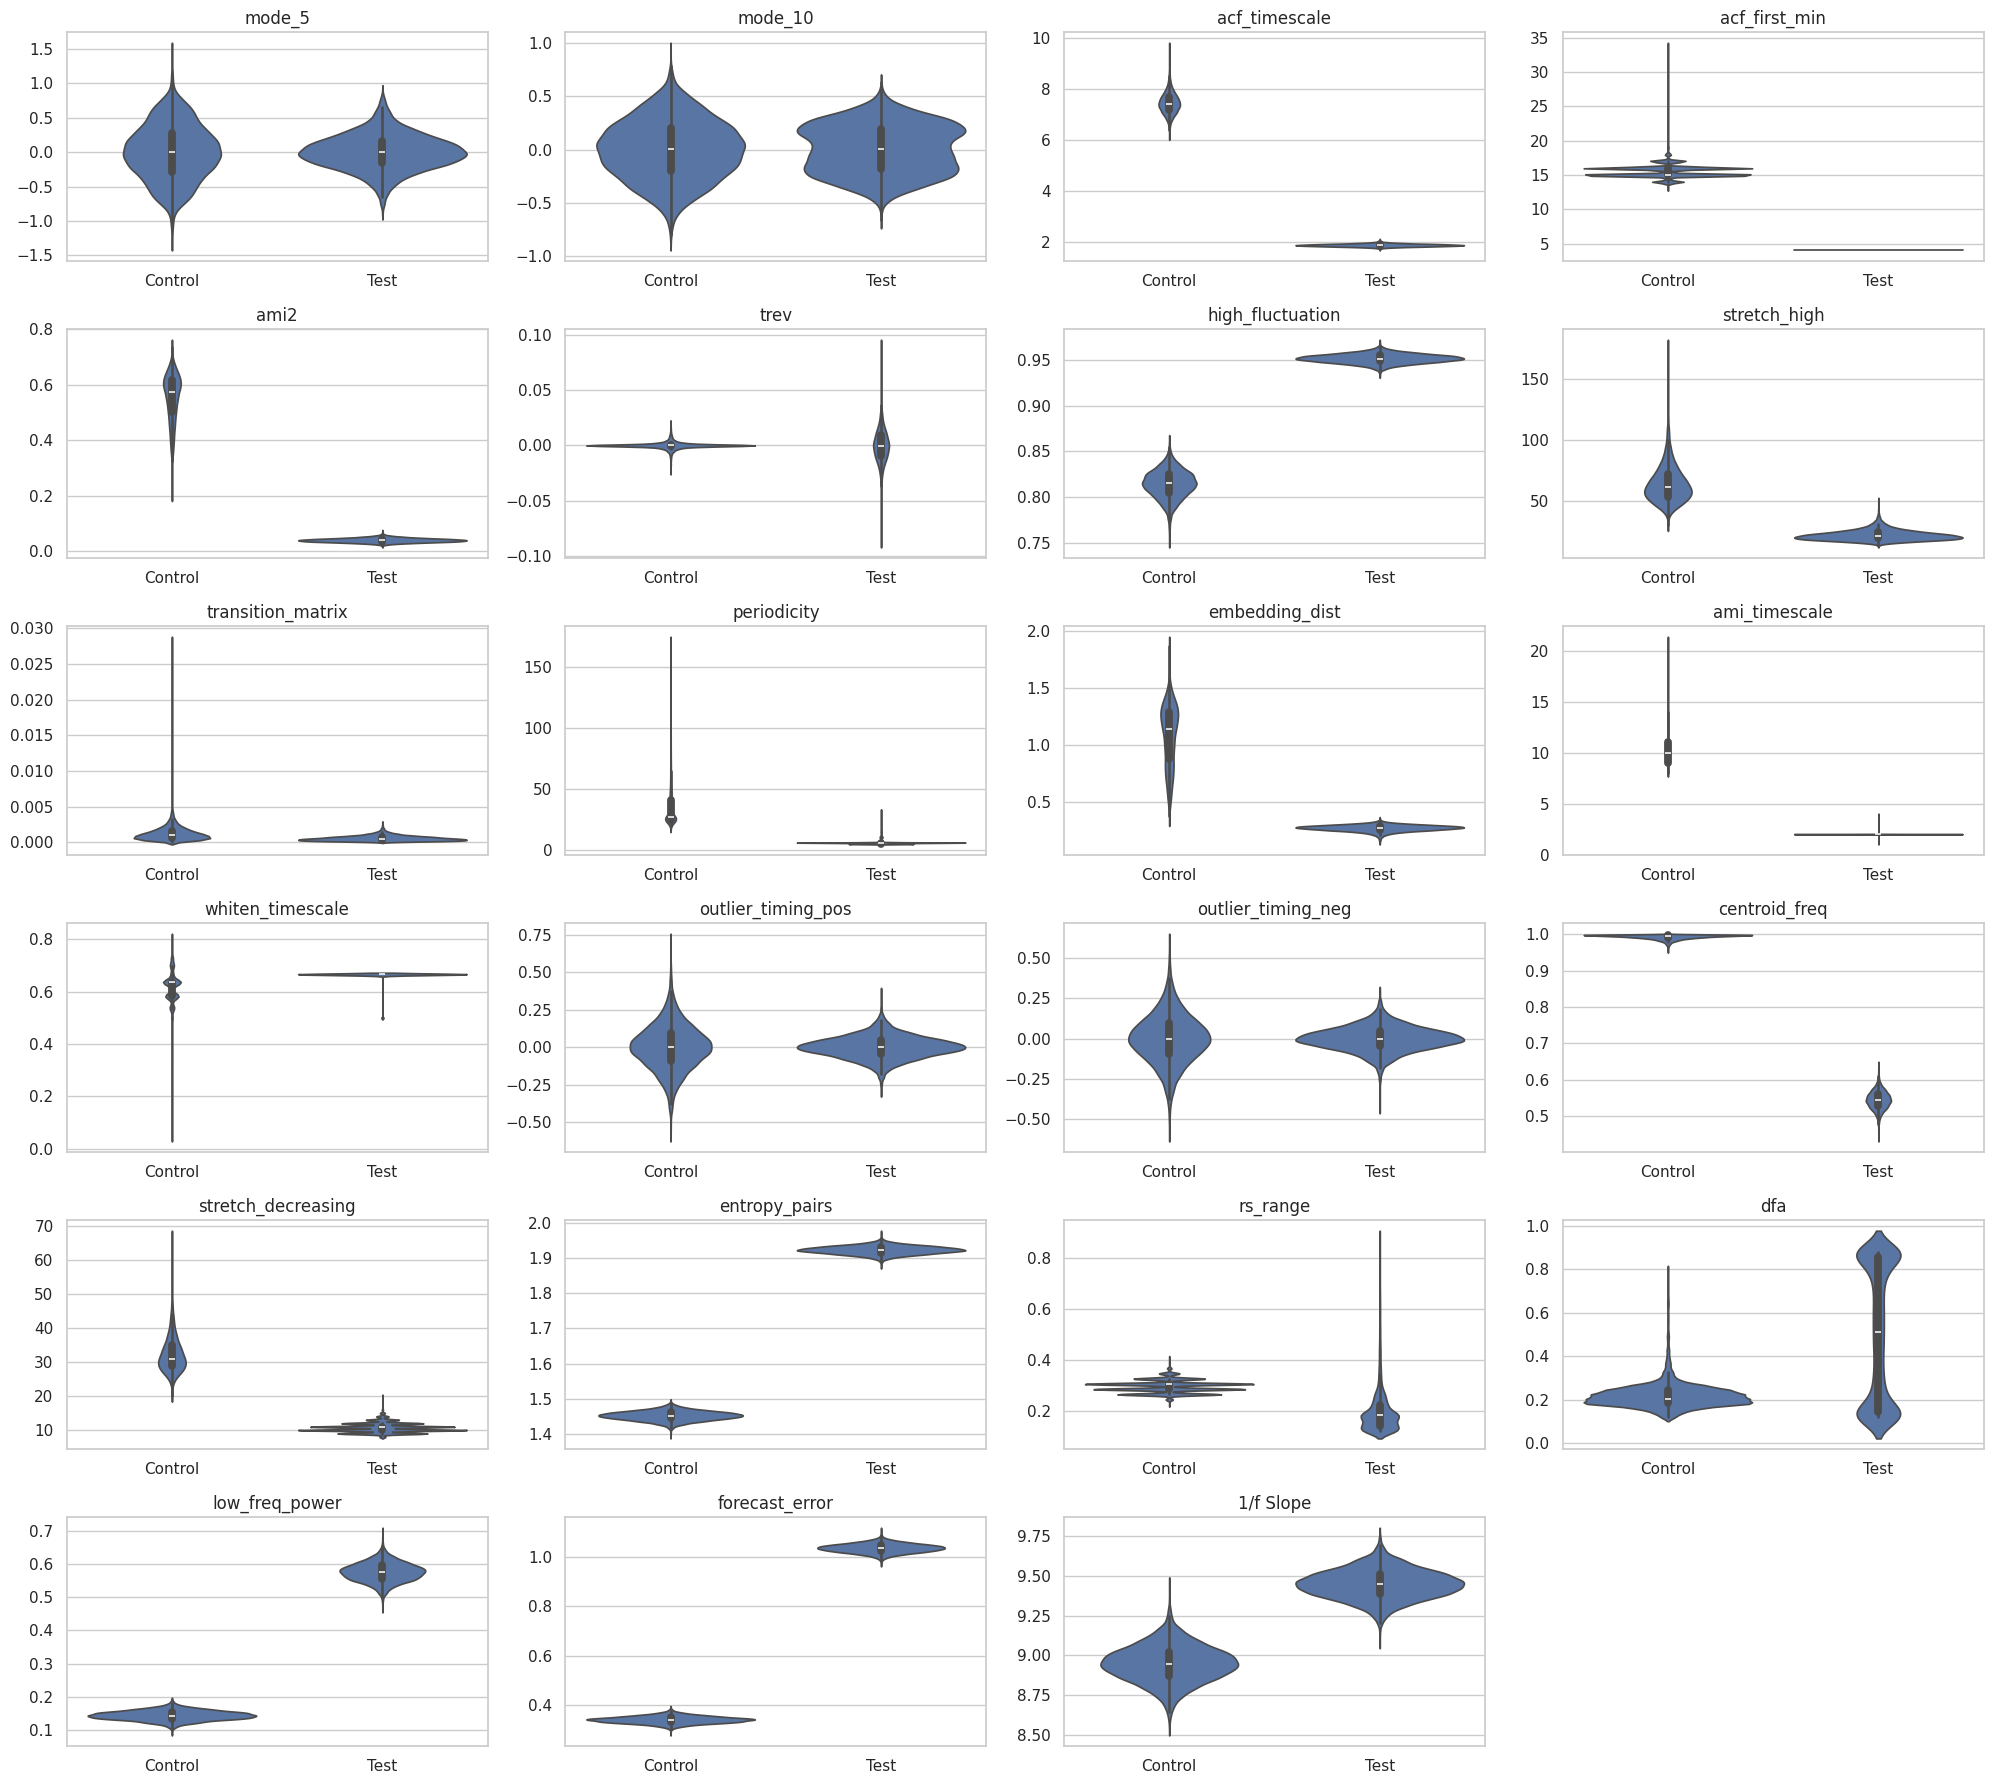

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Catch22 feature names
catch22_features_short = [
    'mode_5',
    'mode_10',
    'acf_timescale',
    'acf_first_min',
    'ami2',
    'trev',
    'high_fluctuation',
    'stretch_high',
    'transition_matrix',
    'periodicity',
    'embedding_dist',
    'ami_timescale',
    'whiten_timescale',
    'outlier_timing_pos',
    'outlier_timing_neg',
    'centroid_freq',
    'stretch_decreasing',
    'entropy_pairs',
    'rs_range',
    'dfa',
    'low_freq_power',
    'forecast_error'
]

# Set style
sns.set(style="whitegrid")

# Extract features and group labels
catch22_features = np.vstack(all_features['catch22'])  # Shape: (n_samples, 22)
slope = np.array(all_features['power_spectrum_parameterization'])  # shape (n_samples,)
groups = emp_data['Group'].values

# Number of subplots
n_rows, n_cols = 6, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 18))
axes = axes.flatten()

# Plot the 22 Catch22 features
for i in range(22):
    ax = axes[i]
    sns.violinplot(x=groups, y=catch22_features[:, i], ax=ax)
    ax.set_title(f'{catch22_features_short[i]}')
    ax.set_xlabel('')
    ax.set_ylabel('')

# Plot the 1/f slope in the 23rd subplot
ax = axes[22]
sns.violinplot(x=groups, y=slope, ax=ax)
ax.set_title('1/f Slope')
ax.set_xlabel('')
ax.set_ylabel('')

# Leave the 24th subplot empty
axes[23].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()